# Branching Out into Isolation Forests

### Tree Based Anomaly Detection

Stephanie Kirmer

ChiPy October 2020

In [1]:
import numpy as np
import pandas as pd
import logging as log
import os
import datetime
import typing
from typing import Callable, List
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Spectral6, brewer
from bokeh.transform import linear_cmap, factor_cmap

# Load data 

From Kaggle - tracks on Spotify

https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv

Let's identify really unusual tracks!

In [2]:
dataset = pd.read_csv("/Users/skirmer/projects/isolationforests/data/data.csv")

Characteristics of the tracks:

In [3]:
dataset.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

# Feature Engineering

Adding some ratios and scaled versions of some features.

In [4]:
def make_ratios(df: pd.DataFrame, featurenames: List[List]):
    ''' Accepts a list of lists (pairs of columns) to be ratioed. Returns the original dataframe with new columns representing ratios of features appended to end.'''

    for i in featurenames:
        df[f'ratio_{i[0]}_{i[1]}'] = df[i[0]]/df[i[1]]
        log.info('Added new feature:' + f'ratio_{i[0]}_{i[1]}')
    return(df)

In [5]:
dataset2 = make_ratios(dataset, featurenames = [['energy', 'acousticness'], ['loudness', 'acousticness'], ['loudness', 'tempo'], ['instrumentalness', 'speechiness']])

In [6]:
dataset2 = dataset2.replace([np.inf, -np.inf], 0)


def scale_all_features(df: pd.DataFrame):
    rdf = df.select_dtypes(include='number')
    rdf2 = pd.DataFrame(minmax_scale(rdf))
    rdf2.columns = [f'{x}_scaled' for x in rdf.columns]
    rdf3 = pd.concat([df.reset_index(drop=True), rdf2], axis=1)
    return(rdf3)

dataset2 = scale_all_features(dataset2)

dataset2['year_bin'] = pd.cut(dataset2['year'],9)

In [7]:
dataset2[['energy', 'energy_scaled']].head()

energy  energy_scaled
0  0.1950         0.1950
1  0.0135         0.0135
2  0.2200         0.2200
3  0.1300         0.1300
4  0.2040         0.2040

In [8]:
dataset2['year_bin'].value_counts(normalize=True) * 100


(1998.0, 2009.0]      12.948108
(1987.0, 1998.0]      12.948108
(1976.0, 1987.0]      12.948108
(1965.0, 1976.0]      12.948108
(1954.0, 1965.0]      12.948108
(2009.0, 2020.0]      12.745646
(1943.0, 1954.0]      11.576197
(1932.0, 1943.0]       6.598826
(1920.901, 1932.0]     4.338793
Name: year_bin, dtype: float64

In [9]:
from plotnine import *
import plotnine.options as pn
from bokeh.plotting import output_file, show

pn.figure_size = (7,3)
# Must downsample to get any reasonable rendering speed
plotset = dataset2.sample(frac=0.25, replace=False, random_state=1)


Loading BokehJS ...

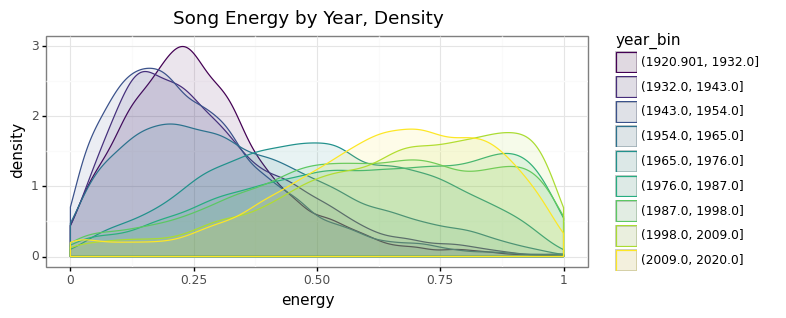

<ggplot: (317965793)>

In [10]:

output_notebook() 

(
    ggplot(plotset, aes(x='energy', color='year_bin', fill='year_bin'))
    + theme_bw()
    + geom_density(alpha=0.1)
    +labs(title = "Song Energy by Year, Density")
)


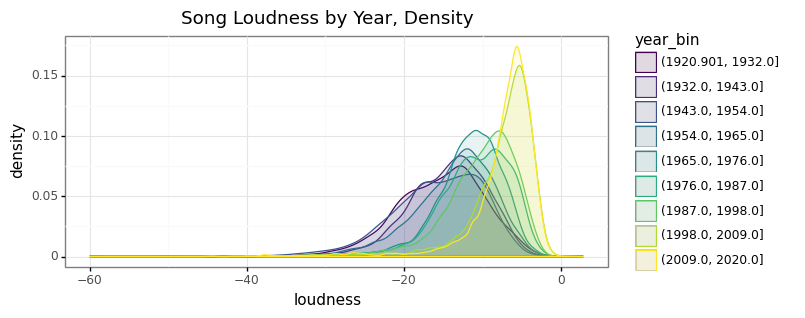

<ggplot: (325775613)>

In [11]:
(
    ggplot(plotset, aes(x='loudness', color='year_bin', fill='year_bin'))
    + theme_bw()
    + geom_density(alpha=0.1)
    +labs(title = "Song Loudness by Year, Density")
)

In [12]:
features = ['acousticness', 'danceability', 'duration_ms', 
            'energy', 'explicit', 'instrumentalness', 
            'key', 'liveness', 'loudness', 'mode', 'popularity',
            'speechiness', 'tempo', 'valence', 'year', 'ratio_energy_acousticness',
            'ratio_loudness_acousticness', 'ratio_loudness_tempo',
            'ratio_instrumentalness_speechiness']

# Model Training

In [146]:

def fit_model(dataframe, feature_list):
    ''' Accepts dataframe and list of features to be used in model training. 
    Returns trained model object and dataset with NAs removed and anomalousness 
    features appended. '''
    rng = np.random.RandomState(42)
    nd = dataframe.dropna()
    #nd = dataframe.fillna(value=0)
    X_train = nd[feature_list]
    clf = IsolationForest(n_estimators=100, max_features=3,
                          contamination=.03, random_state=rng)
    clf.fit(X_train)
    decfn = clf.decision_function(X_train)
    scores = clf.score_samples(X_train)

    y_pred_train = clf.predict(X_train)
    nd.loc[:,'preds'] = pd.Series(y_pred_train).replace({-1:"Anomaly", 1: "Normal"})
#     nd.loc[:,'decision_fn'] = decfn
#     nd.loc[:,'scores'] = scores
#     return(clf, nd)


In [106]:

def predict_on_new(newdata, feature_list, modelobj):
    ''' Accepts dataframe, trained model object, and list of features required by model. 
    Returns dataset with NAs removed and anomalousness features appended. '''
    nd = newdata.dropna()
#     #newdata.fillna(value=0, inplace=True)
    dataframe = nd.loc[:, feature_list]
    decfn = modelobj.decision_function(dataframe)
    scores = modelobj.score_samples(dataframe)

    y_pred_test = modelobj.predict(dataframe)
    nd.loc[:,'preds'] = pd.Series(y_pred_test).replace({-1:"Anomaly", 1: "Normal"})
    nd['decision_fn'] = decfn
    nd['scores'] = scores
    
    return(nd)

In [168]:
rng = np.random.RandomState(42)
nd = X_train.dropna()
    #nd = dataframe.fillna(value=0)
X_train2 = nd.loc[:,features]
clf = IsolationForest(n_estimators=100, max_features=3,contamination=.03, random_state=rng)
clf.fit(X_train2)
decfn = clf.decision_function(X_train2)
scores = clf.score_samples(X_train2)
y_pred_train = clf.predict(X_train2)

X_train2.loc[:,'preds'] = y_pred_train#.replace({-1:"Anomaly", 1: "Normal"})
X_train2.loc[:,'preds_txt'] = X_train2.loc[:,'preds'].replace({-1:"Anomaly", 1: "Normal"})

In [175]:
X_train2.loc[:,'preds_txt'] = X_train2.loc[:,'preds'].replace({-1:"Anomaly", 1: "Normal"})
sum(X_train2['preds_txt'].isna())

0

In [165]:

X_train, X_test = train_test_split(dataset2, test_size=0.3)


In [147]:
#modobj, 
#new_X_train= 
fit_model(X_train, features)


/Users/skirmer/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/skirmer/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [103]:
a1 =  pd.Series(new_X_train[0:100]).replace({-1:"Anomaly", 1: "Normal"})

In [110]:
nd.loc[:, features]

acousticness  danceability  duration_ms  energy  explicit  \
166981       0.61300         0.725       169000   0.373         0   
115984       0.85900         0.387       181029   0.352         0   
114686       0.01870         0.700       354400   0.593         0   
115106       0.01780         0.538       166453   0.476         0   
34316        0.93000         0.539       114867   0.153         0   
...              ...           ...          ...     ...       ...   
53785        0.06580         0.866       272200   0.914         1   
93438        0.03280         0.667       184382   0.804         0   
76343        0.00357         0.677       244840   0.929         1   
116771       0.12000         0.719       104400   0.282         1   
155664       0.88700         0.462        96507   0.188         0   

        instrumentalness  key  liveness  loudness  mode  popularity  \
166981          0.020200   10    0.1180   -15.925     1          39   
115984          0.000000    8    0.1350    -6.864     1          59   
114686          0.010900    1    0.0542    -8.752     0          48   
115106          0.000043    0    0.1010    -9.215     0          51   
34316           0.002590    4    0.1060   -14.560     1           7   
...                  ...  ...       ...       ...   ...         ...   
53785           0.000012    2    0.1350    -2.335     1          42   
93438           0.054400    2    0.0632    -8.583     1          62   
76343           0.000000    3    0.0286    -3.699     0          40   
116771          0.000000    1    0.2930   -17.633     1           0   
155664          0.000000    5    0.7020   -17.237     1          20   

        speechiness    tempo  valence  year  ratio_energy_acousticness  \
166981       0.0494  148.367    0.846  1991                   0.608483   
115984       0.0270   86.168    0.137  2013                   0.409779   
114686       0.1630  171.943    0.614  2000                  31.711230   
115106       0.0490  105.642    0.188  2004                  26.741573   
34316        0.0400  104.732    0.286  1961                   0.164516   
...             ...      ...      ...   ...                        ...   
53785        0.2530   98.958    0.782  2001                  13.890578   
93438        0.0398  105.797    0.759  1977                  24.512195   
76343        0.1490   96.105    0.841  2003                 260.224090   
116771       0.9430  123.694    0.412  1926                   2.350000   
155664       0.0914  170.767    0.728  1962                   0.211950   

        ratio_loudness_acousticness  ratio_loudness_tempo  \
166981                   -25.978793             -0.107335   
115984                    -7.990687             -0.079658   
114686                  -468.021390             -0.050901   
115106                  -517.696629             -0.087229   
34316                    -15.655914             -0.139022   
...                             ...                   ...   
53785                    -35.486322             -0.023596   
93438                   -261.676829             -0.081127   
76343                  -1036.134454             -0.038489   
116771                  -146.941667             -0.142553   
155664                   -19.432920             -0.100939   

        ratio_instrumentalness_speechiness  
166981                            0.408907  
115984                            0.000000  
114686                            0.066871  
115106                            0.000869  
34316                             0.064750  
...                                    ...  
53785                             0.000046  
93438                             1.366834  
76343                             0.000000  
116771                            0.000000  
155664                            0.000000  

[118912 rows x 19 columns]

# Predict on Test Holdout

In [76]:
new_X_test = predict_on_new(newdata=X_test, feature_list=features, modelobj=modobj)
new_X_test.head()

AttributeError: 'int' object has no attribute 'decision_function'

# Analyze Predictions


In [18]:
new_X_test['preds'].value_counts(normalize=True) * 100

Normal     97.005965
Anomaly     2.994035
Name: preds, dtype: float64

In [19]:
new_X_train['preds'].value_counts(normalize=True) * 100

Normal     96.999462
Anomaly     3.000538
Name: preds, dtype: float64

In [20]:
output_notebook() 
# create a new plot with a title and axis labels
p = figure(title="Training Sample Score", y_axis_label='Anomalousness Score', x_axis_label='Tempo, bpm', width=700, height = 300)

source = ColumnDataSource(data=dict(x=new_X_train['tempo'], 
                                y=new_X_train['scores'], 
                                ur = new_X_train['preds'],
                                legend_group= new_X_train['preds']))

colors = factor_cmap('ur', palette=Spectral6, factors=new_X_train.preds.unique()) 

p.circle(color=colors, legend_group = 'legend_group', source=source, fill_alpha=.5, line_alpha = .5)

# show the results
show(p)

Loading BokehJS ...

In [21]:
output_notebook() 
# create a new plot with a title and axis labels
p = figure(title="Test Sample Score", y_axis_label='Anomalousness Score', x_axis_label='Tempo, bpm', width=700, height = 300)

source = ColumnDataSource(data=dict(x=new_X_test['tempo'], 
                                y=new_X_test['scores'], 
                                ur = new_X_test['preds'],
                                legend_group= new_X_test['preds']))

colors = factor_cmap('ur', palette=Spectral6, factors=new_X_test.preds.unique()) 

p.circle(color=colors, legend_group = 'legend_group', source=source)

# show the results
show(p)

Loading BokehJS ...

# Examine Anomalous Songs

In [22]:
anoms = new_X_test[new_X_test['preds'] == 'Anomaly']

In [23]:
pd.crosstab(new_X_test['preds'], new_X_test['year_bin'], normalize='index')


year_bin  (1920.901, 1932.0]  (1932.0, 1943.0]  (1943.0, 1954.0]  \
preds                                                              
Anomaly             0.160550          0.131062          0.153997   
Normal              0.039703          0.063185          0.114761   

year_bin  (1954.0, 1965.0]  (1965.0, 1976.0]  (1976.0, 1987.0]  \
preds                                                            
Anomaly           0.046527          0.028834          0.088467   
Normal            0.131669          0.132580          0.132054   

year_bin  (1987.0, 1998.0]  (1998.0, 2009.0]  (2009.0, 2020.0]  
preds                                                           
Anomaly           0.122543          0.117955          0.150066  
Normal            0.129849          0.130840          0.125359